<a href="https://colab.research.google.com/github/ranggakd/DAIly/blob/main/projects/ethereum%20address/Extract_Smart_Contract_Address_Using_GraphQL_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
[![Open Dev](https://gist.githubusercontent.com/ranggakd/e570f46b5517f90e8102c6a227b64247/raw/cce6e2068d988a06b00c1b3d6f92644a8218d0d6/dev_to.svg)](https://dev.to/ranggakd/leveraging-graphql-api-over-web-scraping-a-backend-approach-14km)

This notebook is Google Colab compatible. More explanation is available on dev.to.

In [7]:
#@markdown *Last running requirement version*

!python -V

# uncomment line below if you are using Linux or Google Colab
!pip freeze | grep -w 'gql'

# uncomment line below if you are using Windows
# !pip freeze | findstr /C:"gql=="

Python 3.9.16
gql==3.4.0


# 1️⃣ Introduction

The task as follows:

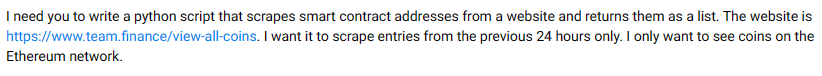

The [website](https://www.team.finance/view-all-coins) has a filter button that we need to click and check the `Ethereum` for Blockchain category and set `the previous 1 day` in the Lock Creation Date.

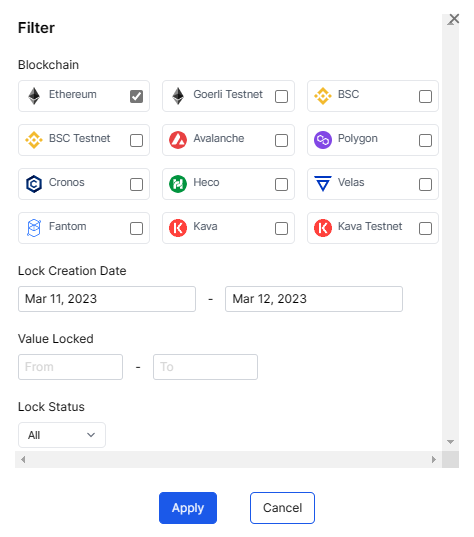

# 2️⃣ Solution

To be honest, our first approach is scraping it using scripting, working the frontend way, but after discussing it with a friend, it is better to work in the backend way.

The approach here is to use the API which is GraphQL if we inspect it via `ctrl + shift + i` on Windows in the `Network` tab. We can see that there are graphql requests that we send as a client. We chose the one with the longest time request.

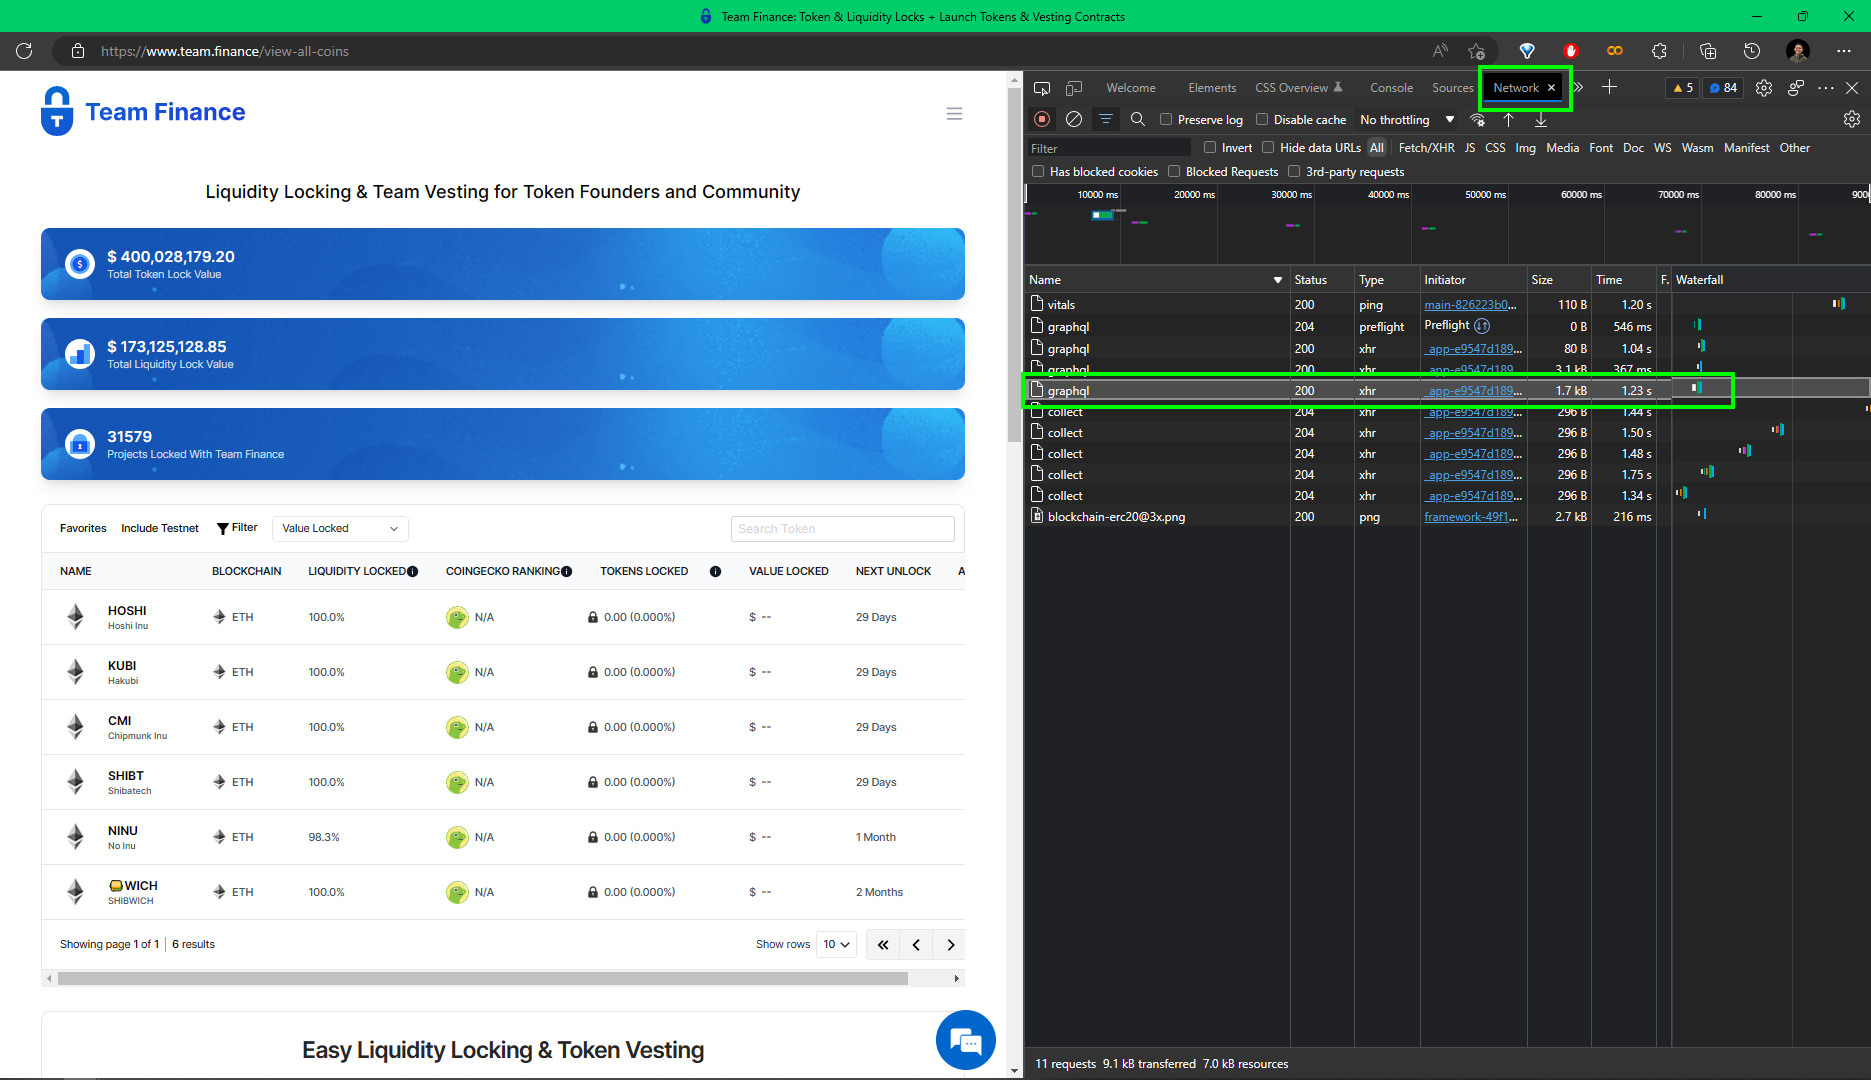

We can take a look at the request `Preview`; it has 6 nodes, the same amount as the addresses on the website.

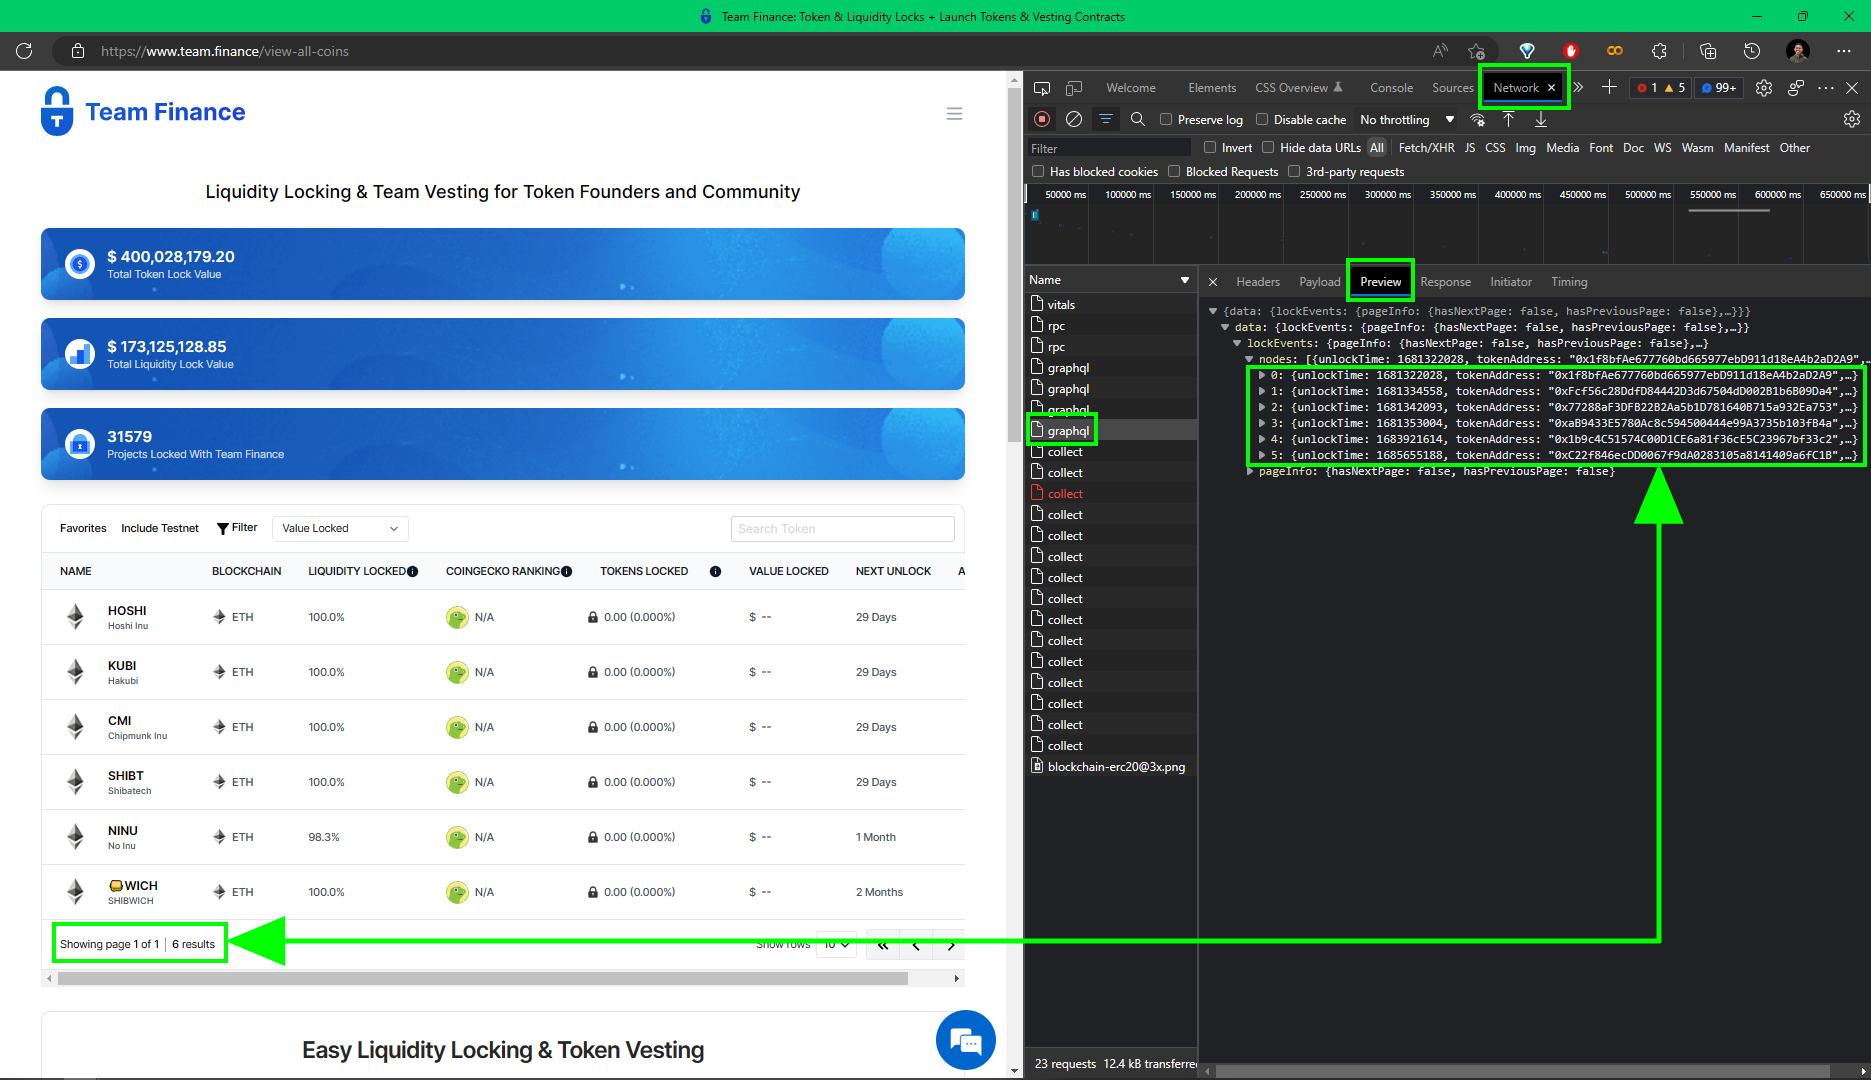

Our endpoint is based on this request `URL` below.

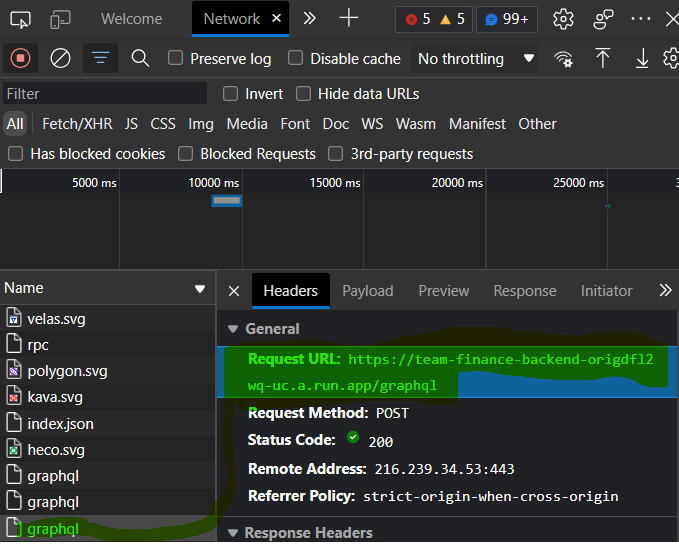

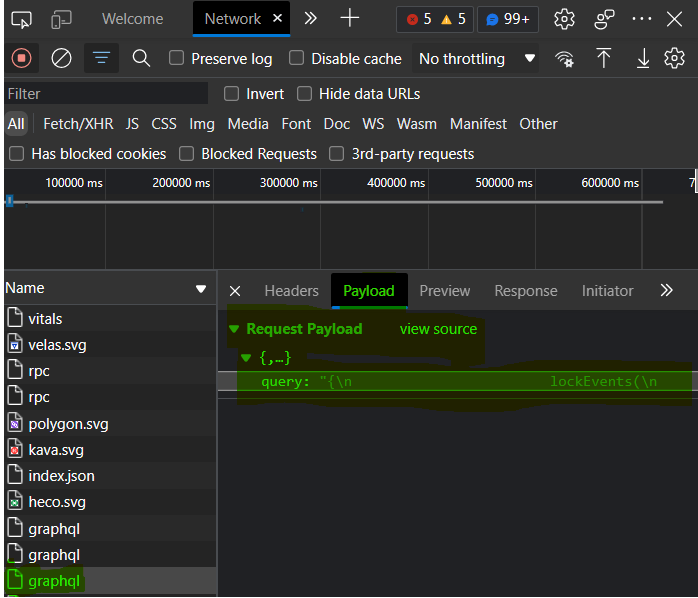

We could check the query that the browser sends when we applied that filter before. It would look like the snippet code below. We could make it dynamic by substituting the value of attributes `lower`, `upper`, and `limit` with their exact name variables, respectively.

```json
{
  lockEvents(
      sorting: {field: unlockTime, direction: ASC}
      filter: {unlockTime: {gt: 0} 
        and: [
          {chainId: {in: ["0x1", ]}}, 
          {createdAt: {between : {lower : "2023-01-31T12:59:00.000Z", upper : "2023-02-01T12:59:00.000Z"} } },
        ]
      }
      paging: {limit: 40, offset: 0}
  ){
      pageInfo {
          hasNextPage
          hasPreviousPage
      }
      nodes{
        unlockTime
        tokenAddress
        network
        tokenTotalSupply
        chainId
        createdAt
        tokenId
        isWithdrawn
      }
  }
}
```

If we are not familiar with GraphQL, do not be afraid because sometimes we feel like we don't understand anything at all as well. In that case, we could talk to Gept (read: ChatGPT) to help us learn faster what is needed at the moment. Here is the explanation.

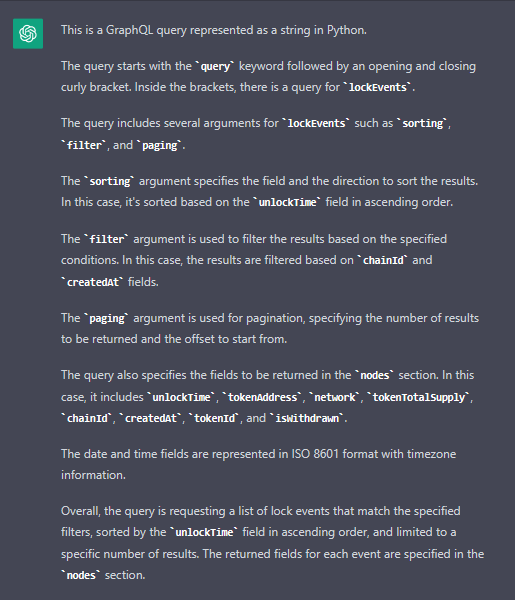

# 3️⃣ Code

## Installation

In [1]:
try:
    import gql
except ImportError as e:
    print(e)
    %pip install gql[all]

No module named 'gql'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 14.3 MB/s eta 0

## Import libraries

In [2]:
from json import dump
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
from datetime import datetime, timezone, timedelta

In [3]:
# constants
URL = 'https://team-finance-backend-origdfl2wq-uc.a.run.app/graphql'
HOURS = 24
UTC_FORMAT = '%Y-%m-%dT%H:%M:%S.%f%z'
LOG_FILE = 'result.json'

In [4]:
# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(url=URL)

# Create a GraphQL client using the defined transport
client = Client(transport=transport)

# Get the current datetime and the previous 24 hours from now in UTC
now_utc = datetime.now(timezone.utc)
previous_1d_utc = now_utc - timedelta(hours=HOURS)

# format the datetimes in ISO 8601 format with UTC offset
upper = now_utc.strftime(UTC_FORMAT)
lower = previous_1d_utc.strftime(UTC_FORMAT)

Here we inject user-defined variables such as `lower`, `upper` and `limit` into a GraphQL query with variable placeholders. We can use the `$` syntax to denote a variable placeholder in the query string, and then pass the variables as a separate dictionary to the `execute()` method of our GraphQL client.

In [5]:
query_str = """
    query Previous1DEth($lower: DateTime!, $upper: DateTime!, $limit: Int!) {
      lockEvents(
          sorting: {field: unlockTime, direction: ASC}
          filter: {unlockTime: {gt: 0}
            and: [
              {chainId: {in: ["0x1", ]}},
              {createdAt: {between : {lower : $lower, upper : $upper} } },
            ]
          }
          paging: {limit: $limit, offset: 0}
      ){
          pageInfo {
              hasNextPage
              hasPreviousPage
          }
          nodes{
            unlockTime
            tokenAddress
            network
            tokenTotalSupply
            chainId
            createdAt
            tokenId
            isWithdrawn
          }
      }
    }
"""

# create GraphQL request
query = gql(query_str)

Note that the variable names in the `variables` dictionary must match the variable names used in the query string.

A GraphQL query is executed _asynchronously_ using the `execute_async` function of a GraphQL client object.

The `await` keyword is used to make the function call asynchronous, which means that the code can continue to execute while waiting for the result of the query. When the query result is ready, the code will resume execution at the point where the `await` statement was used.

The `async` keyword is used to define an asynchronous function, which allows the use of the `await` keyword inside the function body. When a function is marked as async, it returns a coroutine object instead of a regular function object, and the function body can use the `await` keyword to wait for the result of another asynchronous function call.

In [6]:
limit = 10

# increase the limit if there is pagination until exhausted
hasNextPage = True
while hasNextPage:
    variables = {
    "lower": lower,
    "upper": upper,
    "limit": limit
    }
    result = await client.execute_async(query, variable_values=variables)
    hasNextPage = result['lockEvents']['pageInfo']['hasNextPage']
    limit += 10

# store the complete response for log
with open(LOG_FILE, 'w') as f:
    dump(result, f)
nodes = result['lockEvents']['nodes']
addresses = [address['tokenAddress'] for address in nodes]
print(addresses)
print(f"{len(addresses)} addresses")

['0xa5e23E0191605241F11854816aD5971EF6919F4C', '0xc1c2db9C1a6486420b21ddb55187cf834bC50Ef1', '0x7797FB176EfBE2c715F891F10512887E5E7200D8', '0xa9f3b6cA01CbBd87eCC4bfa1E7b28E15542F5718', '0x2901875306725cf7c78b6B233B2f6e6D58819a36', '0x1C11e85e9c49Fc642F8a56e39eFb95F559702836', '0x796A9a43052e1Cb37863E1D33037fd369Bb089EA', '0x718DFE882dcaC6073fAE17Dc70a7044CA0176801', '0x9C5F91B0dF8f49c9a797732CbB10a4dBcA315a52', '0x7EcD80e84F8f01E45008261A1480054746A0C22a', '0x337662f5a5c3d8227287dE9F677E8FaB8DEB851E', '0xbA01A3ee28b3956F450ac04c9bca1a576aa559c6', '0xbcCF8B269Bd8b028ECaB0B3CCDFE066067e52355', '0x22f4D8c2871697b67fb5b811bEE620E70170365F', '0xdf022E8B92451335d79FB740754ce792cBCF4D43', '0x5408245a4D7c685F59cE6D3b8B35916dd6c11A99', '0x1a16B2B93B37A7EF5cB0A4F978CeD45FE14a5486', '0x22f4D8c2871697b67fb5b811bEE620E70170365F', '0xcA64DFFE05f464Ee2bF3A6a2f9eC8eadBDA08659', '0x22f4D8c2871697b67fb5b811bEE620E70170365F']
20 addresses


# 4️⃣ References

[A GraphQL client in Python](https://github.com/graphql-python/gql)

[ChatGPT](https://chat.openai.com/)